In [1]:
import os
import sys
sys.path.append("..")
import canon

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
import keras, keras.layers as L, keras.backend as K

from canon.autoencode.feeder import ImageDataFeeder

IMAGE_DIR = "img/processed_128"
filenames = [filename for filename in os.listdir(IMAGE_DIR)]
IMAGE_SHAPE = plt.imread(os.path.join(IMAGE_DIR, filenames[0])).shape
feeder = ImageDataFeeder(batch_size=30, test_size=500, img_dir=IMAGE_DIR)
X_test = feeder.get_test_set()
print(X_test.shape)

Using TensorFlow backend.


(500, 128, 128)


In [2]:
import canon.autoencode
from canon.autoencode import reset_tf_session

s = reset_tf_session()
model_name = canon.autoencode.models.AE_128_to_256
encoder = canon.autoencode.models.load_encoder(model_name)
decoder = canon.autoencode.models.load_decoder(model_name)
encoder.summary()
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128)          0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 8)       80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        4640      
__________

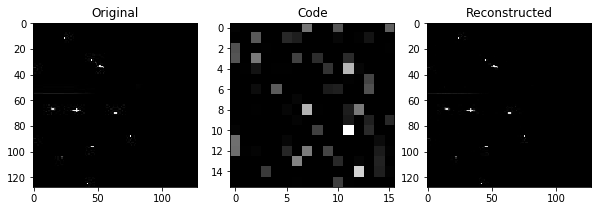

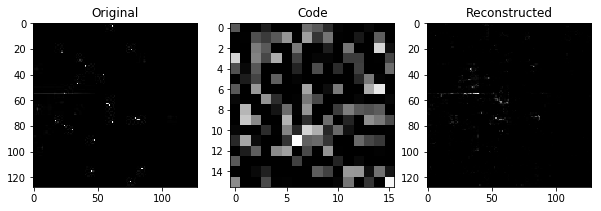

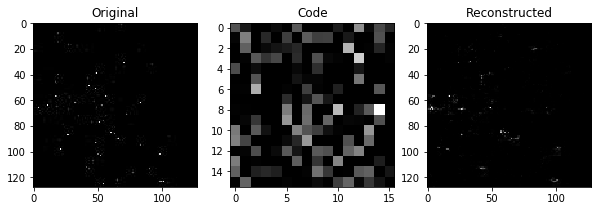

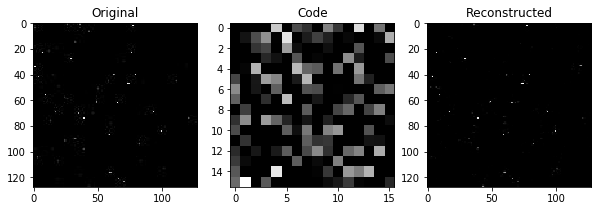

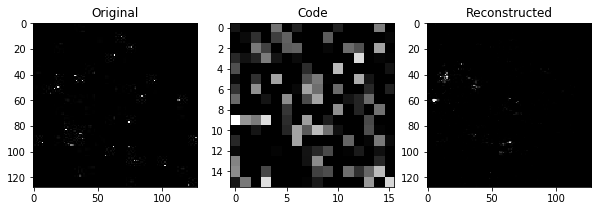

In [3]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    code = encoder.predict(img[None])[0]  # img[None] is the same as img[np.newaxis, :]
    reco = decoder.predict(code[None])[0]

    plt.figure(figsize=(10,50))
    
    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img, cmap='gray')

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([int(np.ceil(np.sqrt(code.shape[-1]))),-1]), cmap='gray')

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco, cmap='gray')
    plt.show()

for i in np.random.choice(np.arange(20), 5):
    img = X_test[i]
    visualize(img, encoder, decoder)